### Random Forest

In [ ]:
from Functions import get_result, get_best_threshold, plot_roc_curve, save_metrics_to_json, auto_cast
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
import json
import mlflow
import numpy as np
import optuna
import pandas as pd
import pickle

Load the datasets for training (remember they are scaled)

In [3]:
filenames = ['X_train.pkl', 'Y_train.pkl', 'X_val.pkl', 'Y_val.pkl', 'X_test.pkl', 'Y_test.pkl']
data_folder = '../data/'
dataframes = [pd.read_pickle(data_folder + filename) for filename in filenames]
X_train, Y_train, X_val, Y_val, X_test, Y_test = dataframes

In [4]:
# The scores we want to look at
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0)
}

#### Hyperparameter Tuning
First, lets set up MLflow

In [20]:
# Read the JSON file
with open('../config.json', 'r') as file:
    config = json.load(file)

# Set the tracking URI for logging using the values from the JSON file
mlflow.set_tracking_uri(uri=f"http://{config['host']}:{config['port']}")

In [21]:
exp_name = "Credit_Card_Approval"
experiment = mlflow.get_experiment_by_name(exp_name)
exp_id = experiment.experiment_id
exp_id

'1'

In [22]:
# Set the current active MLflow experiment
mlflow.set_experiment(experiment_id=exp_id)

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1761771384696, experiment_id='1', last_update_time=1761771384696, lifecycle_stage='active', name='Credit_Card_Approval', tags={'mlflow.note.content': 'This is the Credit Card Approval project. This '
                        'experiment contains the models for credit card '
                        'approval.',
 'project_name': 'credit-card-approval'}>

Here we set up the hyperparameters we want to tune

In [23]:
base_run_name = "random_forest"

In [ ]:
prior_runs = mlflow.search_runs(
    experiment_ids=[exp_id],
    filter_string=f"tags.mlflow.runName LIKE '{base_run_name}%'",
    output_format="pandas",
    max_results=100,
)

print(f"Number of prior runs with base name '{base_run_name}': {len(prior_runs)}")

Number of prior runs with base name 'random_forest': 2


In [25]:
run_name = f"{base_run_name}_v{int(len(prior_runs))+1}"
run_name

'random_forest_v3'

In [27]:
def objective(trial):
    with mlflow.start_run(nested=True):
        # Define hyperparameters
        max_depth = trial.suggest_categorical(
            "max_depth",
            [None] + list(range(5, 51))
        )
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': max_depth,
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
        }

        # Initialize the model
        model = RandomForestClassifier(**params, random_state=42)

        # Train the model
        model.fit(X_train, Y_train)

        # Evaluate the model
        preds = model.predict(X_val)
        metrics = get_result(Y_val, preds)

        # Log the parameters
        mlflow.log_params(params)
        
        # Log the metrics
        mlflow.log_metrics(metrics)

        return metrics['f1']

In [ ]:
artifact_path = "model"
# Initiate the parent run and call the hyperparameter tuning child run logic
with mlflow.start_run(experiment_id=exp_id, run_name=run_name) as parent_run:
    parent_run_id = parent_run.info.run_id
    # Initialize the Optuna study
    study = optuna.create_study(direction='maximize', study_name='RandomForest_Optimization')
    # Execute the hyperparameter optimization trials.
    study.optimize(objective, n_trials=20)

    # Log the best parameters found during the optimization
    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_f1_score", study.best_value)

    # Log tags
    mlflow.set_tags(
        tags={
            "project": "Credit Card Approval",
            "optimizer_engine": "optuna",
            "model_family": "RandomForestClassifier",
            "feature_set_version": 1,
            "version": int(len(prior_runs))+1
        }
    )

    model = RandomForestClassifier(**study.best_params, random_state=42)
    model.fit(X_train, Y_train)

    # Log the final model
    model_info = mlflow.sklearn.log_model(model, 
                             artifact_path=artifact_path,
                             input_example=X_train.iloc[[0]]
                             )
    model_uri = model_info.model_uri

In [ ]:
print(f'parent_run_id: {parent_run_id}')
print(f'model_uri: {model_uri}')

parent_run_id: 4a2bade090f54d1ab0ba50d99643af42
model_uri: models:/m-2cb78661465a44b582159cdba1981a0a


In [39]:
parent_run_id = '4a2bade090f54d1ab0ba50d99643af42'
model_uri = 'models:/m-2cb78661465a44b582159cdba1981a0a'

In [ ]:
runs = mlflow.search_runs(
    experiment_ids=[exp_id],
    filter_string=f"tags.mlflow.parentRunId = '{parent_run_id}'",
    output_format='pandas'
)

In [ ]:
param_cols = [c for c in runs.columns if c.startswith("params.")]

display(runs[[
    'run_id', 
    'metrics.f1', 
    'metrics.recall', 
    'metrics.precision',
    'metrics.accuracy'
    ] + param_cols]
    .sort_values(by='metrics.f1', ascending=False)
    .head(10))

,run_id,metrics.f1,metrics.recall,metrics.precision,metrics.accuracy,params.n_estimators,params.max_features,params.bootstrap,params.class_weight,params.min_samples_leaf,params.min_samples_split,params.max_depth
2,f9de35d004ab4a5282783b8b7283ec8c,0.259259,0.437500,0.184211,0.996483,108,sqrt,False,balanced,10,7,44
4,d43f201a4c0d4c11bb42409218eb9452,0.257669,0.437500,0.182609,0.996453,115,sqrt,False,balanced,10,4,43
5,9a8fe509a0f1446a8d50f18673c32c1c,0.257669,0.437500,0.182609,0.996453,115,sqrt,False,balanced,10,7,43
6,c6385795ad8a4886a5e81cc257fb4b15,0.257669,0.437500,0.182609,0.996453,105,sqrt,False,balanced,10,7,41
3,9f7b313ea9e64c399ea74b1e6022f9dd,0.256098,0.437500,0.181034,0.996424,95,sqrt,False,balanced,10,6,45
9,2a0d141f5dcd4025b8543ca1d9fadc7f,0.250000,0.416667,0.178571,0.996483,221,sqrt,False,balanced,7,7,41
0,8a1eae0492ea4bb7b0db145776862c0a,0.248447,0.416667,0.176991,0.996453,135,sqrt,False,balanced,8,8,33
15,49a2e81c10964ccb8f78d3c748fba22b,0.248447,0.416667,0.176991,0.996453,194,sqrt,False,balanced,8,10,41
7,9736988d0bc1491184c24c561d7d3b8c,0.240506,0.395833,0.172727,0.996483,213,sqrt,False,balanced,5,6,41
18,4cbffebdc9dc4482868eceba5bed63dc,0.240506,0.395833,0.172727,0.996483,276,log2,True,balanced,9,4,36


From the results above, we can see that using class_weight='balanced' is clearly best, which is not surprising, since we have a imbalanced dataset. 
<br>Next, we see that the higher values for min_samples_leaf is in the top. You could try to tune some more, with some higher values in min_samples_leaf, if you wanna see how much it could improve the model. We will however not do that here.
<br>Note also the accuracy for every model. The vast majority got an accuracy of 99% and even the models not predicting 1 risky customer right got it. 

Lets take the model with the hyperparameters that performed the best and test it on our test set and see how well it is doing.

In [32]:
loaded_model = mlflow.sklearn.load_model(model_uri)

In [33]:
# Predict on the val set
val_predictions = loaded_model.predict_proba(X_val)[:, 1]

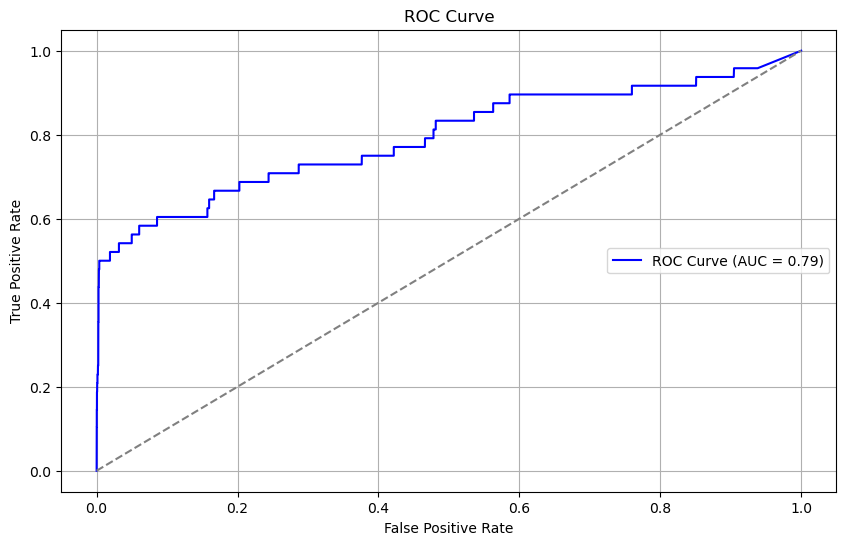

0.7945223070149692

In [34]:
plot_roc_curve(Y_val, val_predictions)

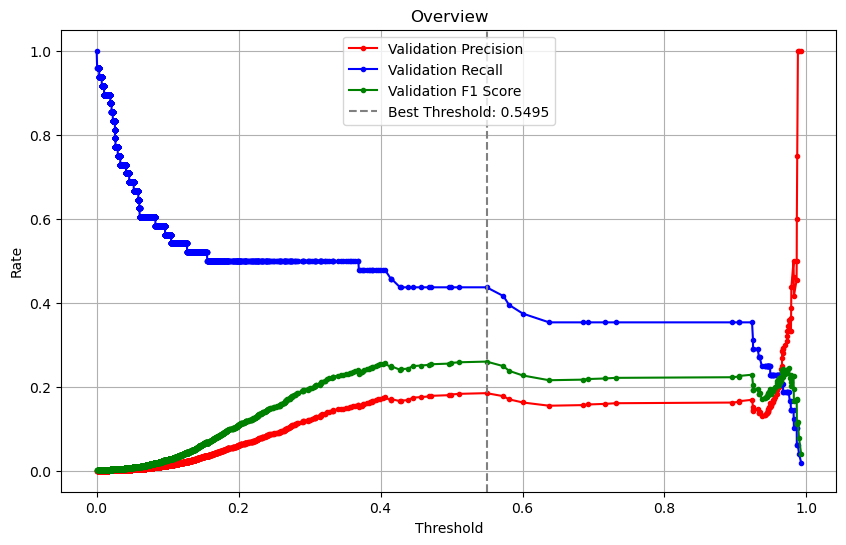

In [35]:
best_threshold = get_best_threshold('Validation', Y_val, val_predictions)

In [36]:
# Predict on the test set
test_predictions = loaded_model.predict_proba(X_test)[:, 1]

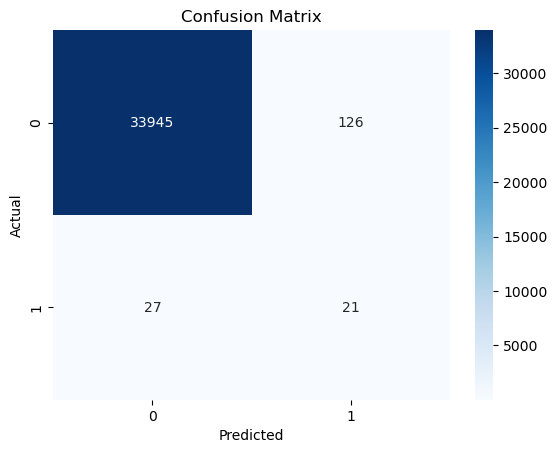

Accuracy     = 1.0
Recall       = 0.44
Precision    = 0.14
F1           = 0.22


In [37]:
result_1 = get_result(Y_test, test_predictions, best_threshold, visualize=True)

For training this model we did not use the validation set, which contains 10% of the original dataset. It could be interresting to see if the model, with the same parameters, could perform better on the test set if it had more data to train on. We'll keep the best threshold, since the model now have seen the data to construct the best threshold and thus be more sure than wants best in general.

Lets merge the training and validation set and predict on the test set again.

In [40]:
best_run = mlflow.get_run(parent_run_id)
best_params = best_run.data.params
best_params = {k: auto_cast(v) for k, v in best_params.items()}
best_params

{'max_depth': 44,
 'n_estimators': 108,
 'min_samples_split': 7,
 'min_samples_leaf': 10,
 'max_features': 'sqrt',
 'bootstrap': False,
 'class_weight': 'balanced'}

In [41]:
# Initialize the RandomForestClassifier with the best hyperparameters from the tuning phase
rfc = RandomForestClassifier(**best_params)

In [42]:
# Train the model
rfc.fit(pd.concat([X_train, X_val]), pd.concat([Y_train, Y_val]))

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=44,
                       min_samples_leaf=10, min_samples_split=7,
                       n_estimators=108)

In [43]:
# Predict on the val set
val_predictions = rfc.predict_proba(X_val)[:, 1]

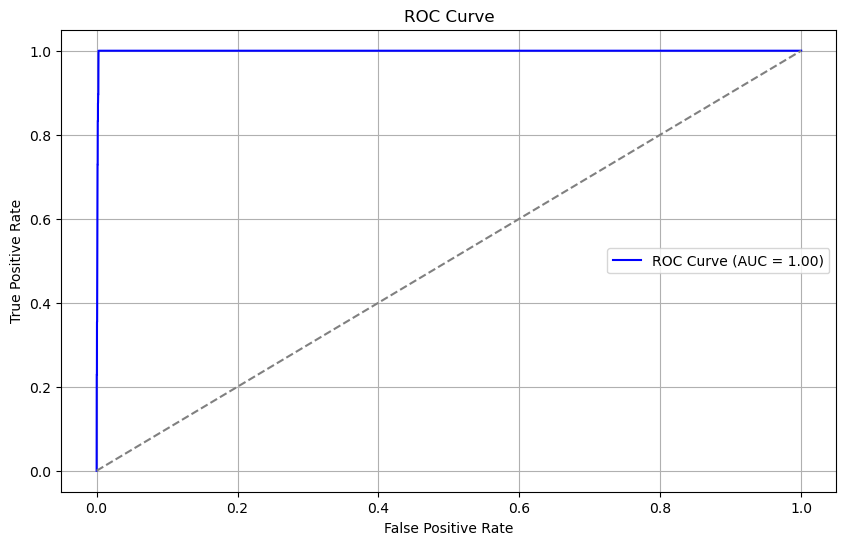

0.9990118383719793

In [44]:
plot_roc_curve(Y_val, val_predictions)

It does perfect on the ROC Curve, which is not surprising, since the model has been trained on the data

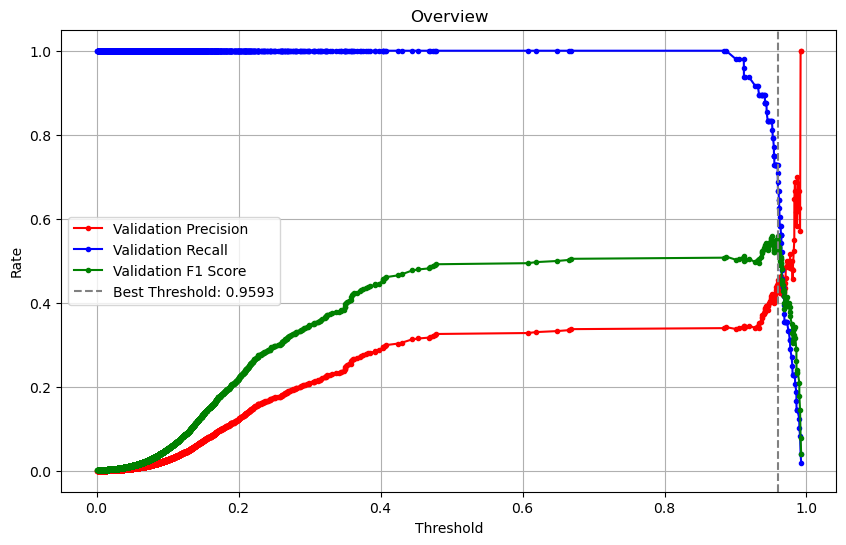

In [45]:
_ = get_best_threshold('Validation', Y_val, val_predictions)

As predicted the best threshold went from 0.55 to 0.96

In [46]:
# Predict on the test set
test_predictions = rfc.predict_proba(X_test)[:, 1]

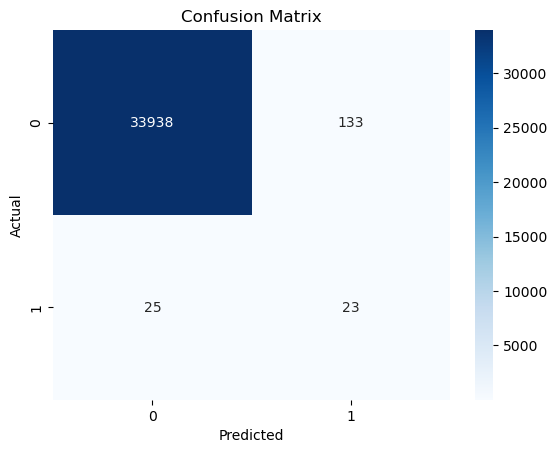

Accuracy     = 1.0
Recall       = 0.48
Precision    = 0.15
F1           = 0.23


In [47]:
result_2 = get_result(Y_test, test_predictions, best_threshold, visualize=True)

In [48]:
if result_2['f1'] > result_1['f1']:
    print('By training our model on more data, we achived a higher performance on the F1 score')
else:
    print('The first model we found, through hyperparameter tuning, is still our best model on the F1 score.')
    print('It had the following scores:')
    print('Recall       =', round(result_1['recall'], 2))
    print('Precision    =', round(result_1['precision'], 2))
    print('F1           =', round(result_1['f1'], 2))

By training our model on more data, we achived a higher performance on the F1 score
